In [1]:
# Compile command
run(`gcc N35_BoxQP.c -o N35_BoxQP.so -O3 -march=native -lopenblas -llapacke -shared -fPIC`)
run(`gcc N3_BoxQP_dsyr.c -o N3_BoxQP_dsyr.so -O3 -march=native -lopenblas -llapacke -shared -fPIC`)

# define the interface call
const N35_BoxQP_lib = "./N35_BoxQP.so"
function call_N35_BoxQP(H::Array{Float64,2},h::Array{Float64,1},epsilon::Float64,alpha::Float64)
    n = length(h)
    z = Array{Float64,1}(undef,n)
    ccall(
        (:N35_BoxQP, N35_BoxQP_lib),
        Cvoid,
        (Ptr{Cdouble},Ptr{Cdouble},Cdouble,Cdouble,Cint,Ptr{Cdouble}),
        H,h,epsilon,alpha,n,z
    )
    return z
end

const N3_BoxQP_dsyr_lib = "./N3_BoxQP_dsyr.so"
function call_N3_BoxQP_dsyr(H::Array{Float64,2},h::Array{Float64,1},epsilon::Float64,alpha::Float64,delta::Float64)
    n = length(h)
    z = Array{Float64,1}(undef,n)
    ccall(
        (:N3_BoxQP_dsyr, N3_BoxQP_dsyr_lib),
        Cvoid,
        (Ptr{Cdouble},Ptr{Cdouble},Cdouble,Cdouble,Cdouble,Cint,Ptr{Cdouble}),
        H,h,epsilon,alpha,delta,n,z
    )
    return z
end

call_N3_BoxQP_dsyr (generic function with 1 method)

In [2]:
using LinearAlgebra, Random
ProbDim = 50:50:1000
RunTime_N35 = Float64[]
RunTime_N3_dsyr = Float64[]
for n in ProbDim
    num_cond = 1e3
    v = vcat(num_cond, (num_cond-1)*rand(n-2).+1, 1)
    U,_ = qr(rand(n,n))
    H = U*Diagonal(v)*U'
    h = 1e3*(1 .- 2 .* rand(n))
    
    num_experiments = ceil(Int, 5000/n)
    
    epsilon = 1e-6
    alpha = 0.3
    start_time = time()
    for i in 1:num_experiments
        z_N35 = call_N35_BoxQP(H,h,epsilon,alpha)
    end
    run_time_N35 = time() - start_time
    run_time_N35 = run_time_N35/num_experiments
    push!(RunTime_N35,run_time_N35)


    epsilon = 1e-6
    alpha = 0.3
    delta = 0.15
    start_time = time()
    for i=1:num_experiments
        z_N3_dsyr = call_N3_BoxQP_dsyr(H,h,epsilon,alpha,delta)
    end
    run_time_N3_dsyr = time() - start_time
    run_time_N3_dsyr = run_time_N3_dsyr/num_experiments
    push!(RunTime_N3_dsyr,run_time_N3_dsyr)
end

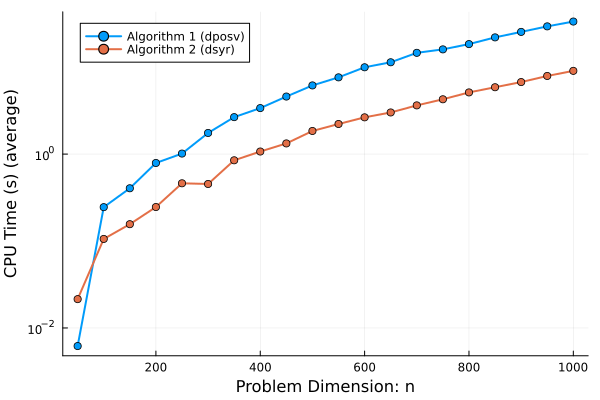

In [3]:
using Plots
plot(ProbDim,RunTime_N35,yscale=:log10,lw=2,marker=:circle,label="Algorithm 1 (dposv)")
plot!(ProbDim,RunTime_N3_dsyr,yscale=:log10,lw=2, marker=:circle, label="Algorithm 2 (dsyr)",xlabel="Problem Dimension: n", ylabel="CPU Time (s) (average)",legend=:topleft)